In [1]:
# installing necessary lib
!pip install --quiet  transformers
!pip install transformers datasets
!pip install --quiet pytorch_lightning
!pip install torchinfo
!pip install sentence_transformers

     |████████████████████████████████| 5.8 MB 6.8 MB/s 
     |████████████████████████████████| 182 kB 79.7 MB/s 
     |████████████████████████████████| 7.6 MB 68.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 5.9 MB/s 
     |████████████████████████████████| 132 kB 64.5 MB/s 
     |████████████████████████████████| 212 kB 72.1 MB/s 
     |████████████████████████████████| 127 kB 78.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
     |████████████████████████████████| 800 kB 6.1 MB/s 
     |████████████████████████████████| 512 kB 60.6 MB/s 
     |████████████████████████████████| 125 kB 18.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg

In [2]:
# Mounting G-Drive to access the data (csv file)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Importing required libraries
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from tables import Column
from pprint import pprint
import torch
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from torchinfo import summary
from transformers import pipeline
from sentence_transformers import SentenceTransformer, util
import pickle

In [4]:
# Train & Test dataset location in drive
train_dataset_location = "/content/drive/MyDrive/Explore/NLP/SentimentAnalysis/DataSet/twitter_training.csv"
test_dataset_location = "/content/drive/MyDrive/Explore/NLP/SentimentAnalysis/DataSet/twitter_validation.csv"

In [5]:
# Reading and creating a dataframe for train and test.
colnames = ['id','source','sentiment','text']
train_df = pd.read_csv(train_dataset_location,names=colnames, header=None)
test_df = pd.read_csv(test_dataset_location,names=colnames, header=None)

In [6]:
train_df.head()

,id,source,sentiment,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [7]:
test_df.head()

,id,source,sentiment,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [8]:
pprint(train_df.shape)
pprint(test_df.shape)

(74682, 4)
(1000, 4)


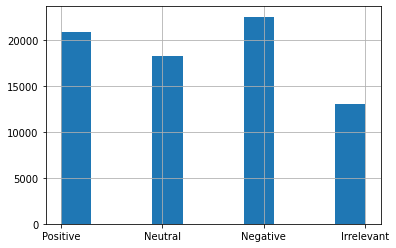

In [9]:
train_df['sentiment'].hist()

In [10]:
# filtering only required columns from train and test dataset
train_df = train_df[['sentiment','text']]
test_df = test_df[['sentiment','text']]
train_df.head()

,sentiment,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [11]:
# Unique sentiments from target column
train_df['sentiment'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

In [12]:
# Converting values in the target column to vectors
target_map = {'Positive':1,'Neutral':2,'Negative':0,'Irrelevant':3}
train_df['target'] = train_df['sentiment'].map(target_map) 
test_df['target'] = test_df['sentiment'].map(target_map) 
train_df = train_df[['text','target']]
test_df = test_df[['text','target']]

In [13]:
train_df.head()

,text,target
0,im getting on borderlands and i will murder yo...,1
1,I am coming to the borders and I will kill you...,1
2,im getting on borderlands and i will kill you ...,1
3,im coming on borderlands and i will murder you...,1
4,im getting on borderlands 2 and i will murder ...,1


In [14]:
# Changing the column name feasuble for model training.
train_df.columns = ['sentence','label']
test_df.columns = ['sentence','label']
train_df.head()

,sentence,label
0,im getting on borderlands and i will murder yo...,1
1,I am coming to the borders and I will kill you...,1
2,im getting on borderlands and i will kill you ...,1
3,im coming on borderlands and i will murder you...,1
4,im getting on borderlands 2 and i will murder ...,1


In [15]:
# Filtering out Na values in both train and test dataset
train_df = train_df[train_df['sentence'].notna()]
test_df = test_df[test_df['sentence'].notna()]

In [16]:
# Saving the refined train & Test dataset.
train_df.to_csv("trainData.csv",index=False)
test_df.to_csv("testData.csv",index=False)

In [17]:
# Loading back both saved train and test dataset.
raw_dataset = load_dataset('csv',data_files={'train':'trainData.csv','test':'testData.csv'})

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-19294c9b313520d0/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [18]:
pprint(raw_dataset)

{'test': Dataset({
    features: ['sentence', 'label'],
    num_rows: 1000
}),
 'train': Dataset({
    features: ['sentence', 'label'],
    num_rows: 73996
})}


In [19]:
# Selecting model checkpoint that is going to be used for training.
checkpoint = 'bert-base-uncased'

In [20]:
# Fetching tokenizer for the check point model selected.
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [21]:
# Function to tokenize the dataset.
def custom_tokenize_function(batch):
  return tokenizer(batch['sentence'],truncation=True)

In [22]:
# Tokenizing both train and test dataset
tokenized_datasets = raw_dataset.map(custom_tokenize_function,batched=True)

  0%|          | 0/74 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [23]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 73996
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1000
    })
})

In [24]:
# Configuring the model
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=4)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [25]:
summary(model)

Layer (type:depth-idx)                                  Param #
BertForSequenceClassification                           --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─Linear: 1-3                                           3,076
Total params: 10

In [26]:
# Configuring Training arguments
training_args = TrainingArguments(
    output_dir='training_dir',
    evaluation_strategy = 'epoch',
    save_strategy = 'epoch',
    num_train_epochs=3,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 64,
)

In [27]:
# Custom function for metrics computation.
def compute_metrics(logits_labels):
  logits, labels = logits_labels
  predictions = np.argmax(logits,axis=-1)
  accuracy = np.mean(predictions==labels)
  f1 = f1_score(labels,predictions,average='macro')
  return {'accuracy':accuracy,'f1':f1}

In [28]:
trainer = Trainer(
    model,
    training_args,
    train_dataset = tokenized_datasets['train'],
    eval_dataset = tokenized_datasets['test'],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics,
)

In [29]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 73996
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 13875
  Number of trainable parameters = 109485316
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than usi

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.419000,0.166408,0.954000,0.953033
2,0.173500,0.124383,0.974000,0.974334
3,0.096800,0.153845,0.978000,0.977973


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 64
Saving model checkpoint to training_dir/checkpoint-4625
Configuration saved in training_dir/checkpoint-4625/config.json
Model weights saved in training_dir/checkpoint-4625/pytorch_model.bin
tokenizer config file saved in training_dir/checkpoint-4625/tokenizer_config.json
Special tokens file saved in training_dir/checkpoint-4625/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence. If sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num exampl

TrainOutput(global_step=13875, training_loss=0.33266019831476984, metrics={'train_runtime': 3344.9735, 'train_samples_per_second': 66.365, 'train_steps_per_second': 4.148, 'total_flos': 8852807926254240.0, 'train_loss': 0.33266019831476984, 'epoch': 3.0})

In [30]:
!ls training_dir

checkpoint-13875  checkpoint-4625  checkpoint-9250  runs


In [31]:
# Load best the model form the better checkpoint manually.
# This can be automated but Manually done for experimentation.
saved_Classification_Model = pipeline('text-classification',model='training_dir/checkpoint-4625',device=0)

loading configuration file training_dir/checkpoint-4625/config.json
Model config BertConfig {
  "_name_or_path": "training_dir/checkpoint-4625",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  

In [43]:
# Validating the model with sample test data.
test_pred = saved_Classification_Model(tokenized_datasets['test']['sentence'])
model_prediction = saved_Classification_Model("The movie was not up to the mark!")
print(model_prediction)

[{'label': 'LABEL_0', 'score': 0.9564249515533447}]


In [33]:
# Saving the final model & Tokenizer to the local storage. 
model_path = '/content/bert_uncase_outputmodel'
saved_Classification_Model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

Configuration saved in /content/bert_uncase_outputmodel/config.json
Model weights saved in /content/bert_uncase_outputmodel/pytorch_model.bin
tokenizer config file saved in /content/bert_uncase_outputmodel/tokenizer_config.json
Special tokens file saved in /content/bert_uncase_outputmodel/special_tokens_map.json
tokenizer config file saved in /content/bert_uncase_outputmodel/tokenizer_config.json
Special tokens file saved in /content/bert_uncase_outputmodel/special_tokens_map.json


('/content/bert_uncase_outputmodel/tokenizer_config.json',
 '/content/bert_uncase_outputmodel/special_tokens_map.json',
 '/content/bert_uncase_outputmodel/vocab.txt',
 '/content/bert_uncase_outputmodel/added_tokens.json',
 '/content/bert_uncase_outputmodel/tokenizer.json')

In [34]:
# Zip & downloading the final model to the local system
# !zip -r '/content/bertSentimentModel.zip' '/content/bert_uncase_outputmodel'/

In [35]:
# from google.colab import files
# files.download("/content/bertSentimentModel.zip")

In [36]:
# Loading back the saved model from its config files generated. (Experimentation)
# Trained on GPU but loading back using CPU.
loaded_model = pipeline('text-classification',model='/content/bert_uncase_outputmodel',device='cpu')

loading configuration file /content/bert_uncase_outputmodel/config.json
Model config BertConfig {
  "_name_or_path": "/content/bert_uncase_outputmodel",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": 

In [37]:
# Function to convert the predicted values to vectors
def generateLabel(d):
  return int(d['label'].split('_')[1])

In [38]:
test_pred = [generateLabel(d) for d in test_pred]

In [39]:
print('acc:',accuracy_score(tokenized_datasets['test']['label'],test_pred))

acc: 0.954


In [40]:
print('f1:',f1_score(tokenized_datasets['test']['label'],test_pred,average='macro'))

f1: 0.9530331282302775


In [41]:
def plot_cm(cm):
  classes = ['Positive','Neutral','Negative','Irrelevant']
  df_cm = pd.DataFrame(cm,index=classes,columns=classes)
  ax=sn.heatmap(df_cm,annot=True,fmt='g')
  ax.set_xlabel('Predicted')
  ax.set_ylabel("Target")

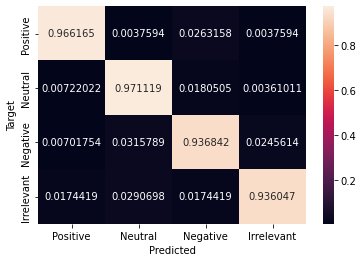

In [42]:
cm =  confusion_matrix(tokenized_datasets['test']['label'],test_pred,normalize='true')
plot_cm(cm)